<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Neural Networks
</h1><br>

For this exercise we'll use Neural Network to recognize hand-written digits (0 to 9). The recognition of hand-written digits is a multi-class classification problem with $k = 10$ classes, i.e $y^i \in \{1, 2, 3, ..., 10\}$. The *Neural Network* would have 3 layers: Input layer, Hidden layer, and Output layer. Since the images are of size 20 x 20 pixels, this gives us 400 input
layer units (not counting the extra bias unit which always outputs +1). The hidden layer will be of size 25 $\rightarrow$ 25 activation units. Finally, the output layer would have 10 nodes since we have 10 classes $\rightarrow h_\theta(x^i) \in \mathbb{R}^{10}$. As a result, we would have 2 parameters' matrices $\Theta^{(1)}$ and $\Theta^{(2)}$. We'll be using *Regularized Logistic Regression* on activation units.

Below is our neural network figure:
<p align="center">
<img src="../images/Neural Network Graph.PNG">

In [1]:
# Import libraries and set up notebook global style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.io import loadmat, whosmat # load Matlab files and inspect objects in those files before loading them
import scipy.optimize as opt # use established optimization algorithms

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight');

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Functions
</h2><br>
Lets write the functions needed to implement our Neural Network.

In [2]:
# Define fn that will randomly initializes parameter matrices
def random_initialize_thetas(input_layer_size, hidden_layer_size, output_layer_size):
        '''
        Assumes all arguments as integers
        Returns two theta matrices randomly selected where each theta_ij would fall within
        [-epsilon, epsilon]
        '''
        epsilon_theta1 = np.sqrt(6) / np.sqrt(input_layer_size + hidden_layer_size)
        epsilon_theta2 = np.sqrt(6) / np.sqrt((hidden_layer_size + 1) + output_layer_size)
        theta1_init = np.random.rand(hidden_layer_size, input_layer_size) * 2 * epsilon_theta1 - epsilon_theta1
        theta2_init = np.random.rand(output_layer_size, hidden_layer_size + 1) * 2 * epsilon_theta2 - epsilon_theta2

        return theta1_init, theta2_init


# Define sigmoid fn that would be applied on activation layers
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Define derivative of sigmoid fn w.r.T z
def sigmoid_gradient(z):
    '''
    z: Activation layer
    Return: derivative of the activation layer l w.r.T z(l)
    '''
    a = sigmoid(z)
    return np.multiply(a, (1 - a))


# Compute forward propagation
def fwd_propagate(X, theta1, theta2):
    '''
    X: feature matrix m x (n + 1)
    thetas: parameter matrices
    Return: output layer (hypothesis) for all examples
    '''
    m = X.shape[0]
    a1 = X 
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, np.ones(m), axis=1) # Add bias unit
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)

    return a3


# Compute regularized cost function
def costFunction(theta, X, y, lambda_, input_layer_size, hidden_layer_size, output_layer_size):
    '''
    theta: parameters vector
    X: feature matrix
    y: label vector
    lambda_: shrinkage parameter
    Return: cost --> scalar
    '''
    # Reshape theta Vector
    theta1 = theta[:hidden_layer_size * input_layer_size].reshape((hidden_layer_size, input_layer_size))
    theta2 = theta[input_layer_size * hidden_layer_size:].reshape((output_layer_size, hidden_layer_size + 1))
    
    m = len(y) # training examples
    
    # Convert label vector to matrix where each yi is column vector with dimension k * 1
    yVec = (np.repeat(np.arange(1, 11)[np.newaxis, :], m, axis=0) == y) * 1
    
    # Get hypothesis for all training examples using fwd prop
    hyp = fwd_propagate(X, theta1, theta2)
    cost = - (1 / m) * np.sum(np.multiply(yVec, np.log(hyp)) + np.multiply(1 - yVec, np.log(1 - hyp)))
    shrinkage = (lambda_ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])))
    
    # Add cost and shrinkage penalty
    J = cost + shrinkage

    return J


# Implement backpropagation
def bck_prop(theta, X, y, lambda_, input_layer_size, hidden_layer_size, output_layer_size):
    '''
    theta: parameters vector
    X: feature matrix
    y: label vector
    lambda_: shrinkage parameter
    Return: gradient vector
    '''
    ## unroll theta vector to the two matrices
    theta1 = theta[:input_layer_size * hidden_layer_size].reshape((hidden_layer_size, input_layer_size))
    theta2 = theta[input_layer_size * hidden_layer_size:].reshape((output_layer_size, hidden_layer_size + 1))

    ## compute fwd prop
    # number of training examples
    m = len(y)
    a1 = X
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    
    # add bias unit
    a2 = np.insert(a2, 0, np.ones(m), axis=1)
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)

    # prepare y
    yVec = (np.repeat(np.arange(1, 11)[np.newaxis, :], m, axis=0) == y) * 1

    # compute deltas
    delta3 = a3 - yVec
    delta2 = np.multiply(delta3.dot(theta2), np.insert(sigmoid_gradient(z2), 0, np.ones(m), axis = 1))
    delta2 = delta2[:, 1:]

    # compute gradients
    theta1_grad = (1 / m) * delta2.T.dot(a1)
    theta2_grad = (1 / m) * delta3.T.dot(a2)

    # compute regularization
    theta1_reg = (lambda_ / m) * (theta1[:, 1:])
    theta2_reg = (lambda_ / m) * (theta2[:, 1:])

    # finalize gradients
    theta1_grad[:, 1:] = theta1_grad[:, 1:] + theta1_reg
    theta2_grad[:, 1:] = theta2_grad[:, 1:] + theta2_reg

    return np.concatenate((theta1_grad.ravel(), theta2_grad.ravel()))


# Compute numerical gradients
def numerical_gradient(X, y, theta, lambda_, input_layer_size, hidden_layer_size, output_layer_size):
    '''
    X: feature matrix
    y: label vector
    theta: parameters vector
    lambda_: shrinkage parameter
    Return: Analytical gradient vector
    '''
    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    epsilon = 1e-4
    for i in range(len(theta)):
        perturb[i] = epsilon
        loss1 = costFunction(theta - perturb, X, y, lambda_, input_layer_size, hidden_layer_size, output_layer_size)
        loss2 = costFunction(theta + perturb, X, y, lambda_, input_layer_size, hidden_layer_size, output_layer_size)

        numgrad[i] = (loss2 - loss1) / (2 * epsilon)
        perturb[i] = 0

    return numgrad


# Compare analytical and numerical gradients
def gradient_comparison(gradient, num_gradient):
    '''
    gradient: gradient vector --> result of back propagation
    num_gradient: numerical gradient vector
    Return: vector of the the difference between them
    '''
    return gradient - num_gradient


# Compute optimal parameters
def compute_theta(theta, X, y, lambda_, input_layer_size, hidden_layer_size, output_layer_size, MaxIter=50):
    '''
    Compute the optimal theta
    Return: parameters matrices
    '''
    theta_opt = opt.fmin_cg(f = costFunction, x0 = theta,
                            args = (X, y, lambda_, input_layer_size, hidden_layer_size, output_layer_size),
                            fprime = bck_prop, maxiter = MaxIter, disp=0)
    # Reshape theta Vector
    theta1 = theta_opt[:hidden_layer_size * input_layer_size].reshape((hidden_layer_size, input_layer_size))
    theta2 = theta_opt[input_layer_size * hidden_layer_size:].reshape((output_layer_size, hidden_layer_size + 1))

    return theta1, theta2


# compute predictions
def predict(theta1, theta2, X):
    '''
    X: feature matrix
    theta: parameter matrices
    '''
    a3 = fwd_propagate(X, theta1, theta2)
    pred = np.argmax(a3, axis= 1) + 1

    return pred

# compute accuracy
def accuracy(predictions, y):
    '''
    predictions: column vector of hypothesis
    y: label variable column vector
    Return: accuracy rate --> scalar
    '''
    m = len(y)
    accuracy = np.mean([1 if predictions[i] == y[i] else 0 for i in range(m)])
    
    return 'accuracy = {:.2f}%'.format(accuracy * 100)

Let's get started by inspecting the data set.

In [3]:
# Load the data
data = loadmat('../data/ex4data1.mat')
weights = loadmat('../data/ex4weights.mat')
y = data['y']
X = data['X']
theta1 = weights['Theta1']
theta2 = weights['Theta2']
X.shape, y.shape, theta1.shape, theta2.shape

((5000, 400), (5000, 1), (25, 401), (10, 26))

As we can see above, the Matlab files contain: 
* $X$: feature matrix with 400 features. Each example is a 20 pixel x 20 pixel grayscale image of the digit. The 20 by 20 grid of pixels is unrolled into 400-dimensional vector $\rightarrow$ 400 features
* $y$: target variable. Note that 0 is 10 in the data for indexing purposes
* $m$: 5000 training example
* $\Theta^1$: first parameter matrix is 25 x 401 which is hidden layer size x (input layer size + 1)
* $\Theta^2$: second parameter matrix is 10 x 26 which is output layer size x (hidden layer size + 1)

Below is all the uniques classes in the target variable as well as an example of 20 random training examples.

unique classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


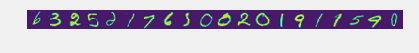

In [4]:
# Print the unique classes
num_classes = len(np.unique(y))
print(f"unique classes: {list(np.unique(y))}")

# Show a sample of 20 images of digits
sample = np.random.choice(X.shape[0], 20)
plt.imshow(X[sample, :].reshape(-1, 20).T)
plt.axis('off');

Below are all the equations regarding our Neural Network classification problem:

The hypothesis function is:
$$P(y^i = 1/x^i,\theta) = h_\theta(x^i) = \frac {1} {1+ \exp^{-\theta^{T}x^i}}$$
The cost function will be:
$$J(\Theta) = - \frac {1} {m} \sum_{i = 1}^{m} \sum_{k = 1}^{K}\Big\{ y^i_k log(h_\theta(x^i))_k + (1 - y^i_k)log(1 - h_\theta(x^i))_k\Big\} + \frac {\lambda} {2m} \sum_{l = 1}^{L - 1} \sum_{i = 1}^{s_l} \sum_{j = 1}^{s_{l + 1}} (\Theta_{ji}^l)^2$$

Since regularization doesn't get applied on the bias unit; therefore:
* $\Theta^1$ dimension is 25 x 400 instead of 25 x 401
* $\Theta^2$ dimension is 10 x 25 instead of 10 x 26
    
The gradients will be:$$\Delta_{ij}^l = a_j^l * \delta_i^{l + 1}$$

$$D_{ij}^l = \frac{1}{m}\Delta_{ij}^l + \frac{\lambda}{m}\Theta_{ij}^l\quad if\,j \neq 0$$ since we don't apply regularization on the bias unit.

$$D_{ij}^l = \frac{1}{m}\Delta_{ij}^l \quad\quad\quad\quad if\,j = 0$$

In [5]:
# Set up some global variables
m = len(y)

# Add bias to the feature matrix
X = np.insert(X, 0, np.ones(m), axis = 1)
input_layer_size = X.shape[1]
hidden_layer_size = 25
output_layer_size = len(np.unique(y))
m, X.shape, input_layer_size, output_layer_size

(5000, (5000, 401), 401, 10)

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Sigmoid function and It's derivative
</h2><br>
$$sigmoid(z) = g(z) = \frac {1}{1 + e^{-z}}$$
$$g^{'}(z) = \frac {e^{-z}}{1 + e^{-z}} = g(z)(1 - g(z))$$
For large absolute values of z, the gradinet is close to 0. When z = 0, the gradient is 0.25.

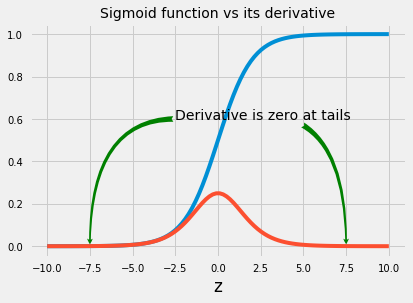

In [6]:
# Plotting both sigmoid fn and its derivative
el = Ellipse((2, -1), 0.5, 0.5)
z = np.linspace(-10, 10, 100)
plt.plot(z, sigmoid(z))
plt.plot(z, sigmoid_gradient(z))
plt.xlabel('z')
plt.annotate('',
             xy = (-7.5, 0), xytext = (-2.5, 0.6),
             arrowprops=dict(arrowstyle="fancy", fc='green', ec="none", patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90", facecolor='green'))
plt.annotate('Derivative is zero at tails',
             xy = (7.5, 0), xytext = (-2.5, 0.6),
             arrowprops=dict(arrowstyle="fancy", fc='green', ec="none", patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90", facecolor='green'), fontsize = 14)
plt.title('Sigmoid function vs its derivative', fontsize = 14);

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Random Initialization
</h2><br>
When training neural networks, it's very important to not assign the parameters in $\Theta^ls$ the same values when initializing those matrices such as assigning them zeros because all updates and gradients will be the same on every iteration and our learning algorithm won't learn anything. Therefore, it's important to randomly initialize the parameters to break symmetry. One good strategy is to randomly select values for $\Theta^l$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in}$ is *incoming connection* and $L_{out}$ is outgoing connection. As shiwn below, both theta matrices are within the $[-\epsilon_{init}, \epsilon_{init}]$ range. So we're good to go!

In [7]:
theta1_init, theta2_init = random_initialize_thetas(input_layer_size, hidden_layer_size, output_layer_size)
print(theta1_init.shape, theta2_init.shape)
print(np.min(theta1_init), np.max(theta1_init))
print(np.min(theta2_init), np.max(theta2_init))

(25, 401) (10, 26)
-0.118657546258 0.118630939169
-0.407727273733 0.404503927386


<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Numerical gradient checking
</h2><br>
Before implementing the neural network, it's a good practice to check if our *backpropagation* implementation is correct. To do this, we'll first initialize $\Theta^1$ and $\Theta^2$ and we did that above. Next, calculate the gradients from our backpropagation implementation and compare it with *analytical gradient*. We can numerically check gradients by using two-sided $\epsilon$.
$$Let \quad \Theta^{i+} = \Theta + \begin{bmatrix}0\\0\\\vdots\\\epsilon\\\vdots\\0 \end{bmatrix};\quad \Theta^{i-} = \Theta - \begin{bmatrix}0\\0\\\vdots\\\epsilon\\\vdots\\0 \end{bmatrix}$$

$$\Rightarrow \quad f_i(\Theta) = \frac{\partial}{\partial\Theta_i}J(\Theta)  = \frac{J(\Theta + \epsilon) - J(\Theta - \epsilon)}{2\epsilon}$$
Using $\epsilon = 10^{-4}$ (which is a good value to assume), **the relative difference between our gradient unrolled vector and numerical gradient vector will be less than $1e^{-9}$ if our backpropagation is correct**.

As the results below confirms, the biggest defference between numerical gradients and gradients from our backpropagation implementation is close to $1e^{-10}$ which is less than $1e^{-9}$. Therefore, our backpropagation implementation is correct.

In [8]:
# Unroll initialized thetas into a vector
theta_init = np.concatenate((theta1_init.ravel(), theta2_init.ravel()))
grad = bck_prop(theta_init, X, y, 1, input_layer_size, hidden_layer_size, output_layer_size)
num_grad = numerical_gradient(X, y, theta_init, 1, input_layer_size, hidden_layer_size, output_layer_size)
diff = gradient_comparison(grad, num_grad)
np.min(diff), np.max(diff)

(-1.6380288792028352e-10, 1.8834522830246669e-10)

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Backpropagation and Learning Parameters
</h2><br>
The intuition behind backpropagation is as follows:
1. For each training example $(x^i, y^i)$, we'll do forward propagation and compute the output layer which is $h_\Theta(x)$
2. Calculate for each node $j$ in layer $l$ the error term $\delta_j^l$ that measures how much that node is responsible for the errors in the output node. $\delta_j^l$ in hidden layers can be thought of as the weighted average of error term of the nodes in layer $(l + 1)$.
The cost function for the current problem is:
$$J(\Theta) = - \frac {1} {5000} \sum_{i = 1}^{5000} \sum_{k = 1}^{10}\Big\{ y^i_k log(h_\theta(X^i))_k + (1 - y^i_k)log(1 - h_\theta(X^i))_k\Big\} + \frac {\lambda} {10000} \Big\{\sum_{i = 1}^{25} \sum_{j = 1}^{400} (\Theta_{ji}^1)^2 + \sum_{i = 1}^{10} \sum_{j = 1}^{25} (\Theta_{ji}^2)^2\Big\}$$

In [9]:
# Trying two values for lambda: 0.1, 1
theta1_opt_0, theta2_opt_0 = compute_theta(
    theta_init, X, y, 0.1, input_layer_size, hidden_layer_size, output_layer_size, 250)

theta1_opt_1, theta2_opt_1 = compute_theta(
    theta_init, X, y, 1, input_layer_size, hidden_layer_size, output_layer_size, 250)

pred_0 = predict(theta1_opt_0, theta2_opt_0, X)
pred_1 = predict(theta1_opt_1, theta2_opt_1, X)
print("Using lambda = 0:", accuracy(pred_0, y))
print("Using lambda = 1:", accuracy(pred_1, y))

Using lambda = 0: accuracy = 100.00%
Using lambda = 1: accuracy = 99.44%


As indicated above, the accuracy rate is $100\%$ when $\lambda = 0.1$ and $99.44\%$ when $\lambda = 1$. Of course this is the training accuracy rate which is higher than test accuracy rate and it's obvious that our learning algorithm suffers from overfitting. We can change the values of $\lambda$ to avoid overfitting by increasing it.

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Conclusion
</h2><br>
* Choose the **Neural Network** architecture. That is, pick how many hidden layers we want and within each hidden layer how many activation units (nodes) we want. The more the layers and nodes $\rightarrow$ the deeper and wider the network is $\rightarrow$ more complex and computationally expensive and may overfit the data; however, it may give us better accuracy.
* Initialize theta (parameters) matrices by randomly assigning values to $\theta_{ij}^l$ using the following formula:
$$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$$
$$\Theta^l = random(L_{in} + L_{out}) * 2 * epsilon_{init} - epsilon_{init}$$
    Where $L_{in}$ is layer size of incoming connection and $L_{out}$ is layer size of outgoing connection.
    * This will gurantee that $\Theta^l$ will be uniformly distributed in the range $[-\epsilon_{init}, \epsilon_{init}]$
    * Also, this will break the symmetry that may happen if we assign all $\Theta$'s the same value such as zero or $\Theta^l$ at each layer to have the same value. Having symmetry will always result in the same update and our learning algorithm won't be able to learn anything because all gradients will be the same
* Compare the results of the difference of gradients from the backpropagation and numerical gradients. The difference should be less than $1e^{-10}$. Doing this will give us an indication of whether our backpropagation implementation is correct.
* Turn off gradient checking because it's very slow process and will add the nothing to our model
* Use the initialized thetas to calculate all activation layers and the output.
* Backpropagate to get all the gradients
* Update the initialized theta with gradients we got and the process would continue until we find a local optimum
* Note that the cost function is no longer convex $\rightarrow$ the optimization algorithm such *Gradient Descent* may stuck in a local minimum and not be able to find global minimum. However, this is not a real issue in practice.